# This notebook

* Explores the x and y parameters in the plot
    * Serialized into functions

In [1]:
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle


import sys
import os
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/multiphase_turb/codes'))
from jason import plotting_def, plot_prettier

plotting_def()

# The function

In [2]:
"""Define constants"""

class unit():
    def __init__(self):        
        # length, time, and mass constants
        self.CONST_pc  = 3.086e18
        self.CONST_yr  = 3.154e7
        self.CONST_amu = 1.66053886e-24
        self.CONST_kB  = 1.3806505e-16
        self.unit_length = self.CONST_pc*1e3  # 1 kpc
        self.unit_time   = self.CONST_yr*1e6  # 1 Myr
        self.unit_density = self.CONST_amu    # 1 mp/cm-3
        self.unit_velocity = self.unit_length/self.unit_time
        self.KELVIN = self.unit_velocity*self.unit_velocity*self.CONST_amu/self.CONST_kB
        self.unit_q = (self.unit_density * (self.unit_velocity**3))/self.unit_length
        self.g = 5/3
        
        # avg atomic mass
        Xsol = 1.0
        Zsol = 1.0
        
        X = Xsol * 0.7381
        Z = Zsol * 0.0134
        Y = 1 - X - Z
        
        self.mu  = 1.0/(2.*X+ 3.*(1.-X-Z)/4.+ Z/2.);
        self.mue = 2.0/(1.0+X);
        self.muH = 1.0/X;
        self.mH = 1.0

        # alpha values for different sims
        self.alpha_hyd = 2 ** (1 / 3)  # 1.26 # 1.383
        self.alpha_mhd = (2 * 4.2 / 0.77) ** (1 / 3)

u = unit()
u.mu

0.5990624672387714

In [3]:
def calc_T(P, rho):
    """
    Calculates temeprature from constants
    ----------
    P: gas pressure
    rho: gas density
    """
    T = P/rho * u.KELVIN * u.mu
    return T

def calc_cs(T):
    """
    Calculates sound speed
    ----------
    T: temperature
    mu: avg atomic number of the gas
    """
    # convert to cm
    m_to_cm = 100

    # return np.sqrt(g.g*R*T_hot/M) * m_to_cm/g.unit_velocity
    # return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) * m_to_cm / u.unit_velocity
    return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) / u.unit_velocity

def calc_mach(v_turb, P, rho):
    """
    Calculates the Mach number
    ----------
    v_turb: turbulence velocity
    P, rho
    """
    T = calc_T(P, rho)
    cs = calc_cs(T)
    print(f'cs = {cs}')
    return v_turb / cs

def calc_dedt_mach(mach, P, rho, L):
    """
    Returns required dedt for a given Mach number, density, temperature, and box size
    """
    # calculate sound speed first
    T = calc_T(P, rho)
    cs_new = calc_cs(T)
    print(f"cs_hot: {cs_new}")

    dedt_req = rho * (cs_new**3) * (L**2) * (mach**3) / (u.alpha_hyd**3)
    return dedt_req


def calc_dedt_vturb(v_turb, rho, L):
    """
    Returns required dedt for a given turbulent velocity, density, and box size

    Does NOT calculate sound speed, so no pressure required
    """
    
    dedt_req = rho * v_turb**3 * (L**2) / (u.alpha_hyd**3)
    return dedt_req

def find_ind_l(seq, val):
    seq = list(seq)
    return seq.index(list(filter(lambda x: x>val, seq))[0])

In [4]:
import pickle

# trial = '240606_0.6_5'  # for 4e4 plot
# trial = '240610_0.6_2032'  # for 8e3 plot

def load_lshat(rp = None, verbose = False):
    # Import the cooling function from Hitesh's scripts
    import sys
    sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/multiphase_turb/athena/cooling_scripts'))
    import cooling_fn as cf
    sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/multiphase_turb/athena/helper_scripts'))
    import v_turb as vt

    # temperature range
    T_arr = np.logspace(np.log10(rp['T_floor']),
                        np.log10(rp['T_ceil']), 100)  # in kelvin
    rho_arr = rp['rho_hot'] * rp['T_hot'] / T_arr
    
    """
    Cooling & Heating functions
    """
    Gamma_n_arr = 1e-26 / rho_arr
    Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)
    
    """
    Cooling & Heating rates
    """
    heating_rate = 1e-26 * rho_arr
    cooling_rate = Lambda_arr * rho_arr**2
    
    """
    Timescale
    """
    tcool_arr = np.vectorize(cf.tcool_calc)(
        rho_arr, T_arr, Zsol=1.0, Lambda_fac=1.0, fit_type="max"
    )

    """
    Shattering length
    """
    def calc_cs(T):
        m_to_cm = 100
        return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) / u.unit_velocity
    t_cool_func = lambda T : cf.tcool_calc(rp['rho_hot'] * rp['T_hot'] / T, T, Zsol=1.0, Lambda_fac=1.0, fit_type="max")
    l_shatter = np.vectorize(t_cool_func)(T_arr) * calc_cs(T_arr)

    """
    Minimum l_shatter
    """
    # calculate geometric mean T_mix
    # the two limits
    T_cold = rp['T_cloud']  # set cold temperature to that of cloud
    T_hot = rp['T_hot']

    """T_mix calculations"""
    # the params in range
    T_ind_low, T_ind_high = find_ind_l(T_arr, T_cold), find_ind_l(T_arr, T_hot)
    T_range = T_arr[T_ind_low : T_ind_high]
    tcool_range = tcool_arr[T_ind_low : T_ind_high]
    
    T_tcoolmin = T_range[np.argmin(tcool_range)]  # the temperature corresponding to the lowest t_cool
    T_mix = np.sqrt(T_tcoolmin * T_hot)  # use the temperature at which t_cool is lowest instead of this:  # T_mix = np.sqrt(T_cold * T_hot)  # use the cloud temperature

    t_cool_min = np.min(tcool_range)
    t_cool_mix = t_cool_func(T_mix)
    t_cool_cold = t_cool_func(T_cold)
    
    l_shatter_min = np.min(l_shatter[T_ind_low : T_ind_high])

    if verbose:
        print(f'T_cold = {T_cold}')
        print(f'T_hot = {T_hot:.2e}')
        print(f'T_mix = {T_mix:.2e}')
        print(f't_cool,mix,og = {t_cool_func(np.sqrt(T_cold * T_hot)):.2e}')
        print(f't_cool,mix = {t_cool_mix:.2e}')
        print(f't_cool,cold = {t_cool_cold:.2e}')
        print(f't_cool_min = {t_cool_min:.2e}')
        print(f'l_shatter_min = {l_shatter_min:.2e}')
    
    def plot_tvlines():
        plt.axvline(x=rp['T_floor'], lw=1, color="k", linestyle="--")
        plt.axvline(x=rp['T_cloud'], lw=1, color="slateblue", linestyle="--")
        plt.axvline(x=T_tcoolmin, lw=1, color="slateblue", linestyle="-.", alpha=0.2)
        plt.axvline(x=T_mix, lw=1, color="green", linestyle="-.", alpha=0.2)
        plt.axvline(x=rp['T_hot'], lw=1, color="orangered", linestyle="--")
        # plt.axvline(x=T_cut color="k", linestyle="")
    
    if verbose:
        """Cooling function"""
        plt.figure(figsize=(4, 3))
        plt.plot(T_arr, Lambda_arr, label=r"$\Lambda(T)$")
        
        plt.ylabel(r"$\Lambda(T)$  $[10^{-23}  \mathrm{ergs ~ cm}^3/\mathrm{s}]$", fontsize=14)
        plt.xlabel(r"$T$(K)", fontsize=14)
        
        plt.yscale("log")
        plt.xscale("log")
        
        plot_tvlines()
        plt.show()

        """Cooling rate"""
        plt.figure(figsize=(4, 3))
        plt.plot(T_arr, cooling_rate - heating_rate, color='green', label=r"$n^2\Lambda(T) - n\Gamma(T) $")
        plt.plot(T_arr, cooling_rate, color='blue', label=r"$n^2\Lambda(T)$")
        plt.plot(T_arr, heating_rate, color='red', label=r"$n\Gamma(T)$")
        
        plt.ylabel(r"Cooling/Heating rate", fontsize=14)
        plt.xlabel(r"$T$(K)", fontsize=14)
        
        # plt.yscale("log")
        plt.xscale("log")
        
        # plt.ylim(0.0, 5e-15)
        
        plt.legend()
        plot_tvlines()
        plt.show()

        """Cooling timescale"""
        plt.figure(figsize=(4, 3))
        plt.plot(T_arr, tcool_arr, label=r"$\Lambda(T)$")
        plt.ylabel(r"$t_{\rm cool} [u]$", fontsize=14)
        plt.xlabel(r"$T$(K)", fontsize=14)
        plt.yscale("log")
        plt.xscale("log")
        plot_tvlines()
        plt.show()
        
        """l_shatter"""
        plt.figure(figsize=(4, 3))
        # shatter length scale
        plt.plot(T_arr, l_shatter)
        plt.ylabel(r"$l_{\rm shatter}$", fontsize=14)
        plt.xlabel(r"$T$(K)", fontsize=14)
        plt.yscale("log")
        plt.xscale("log")
        plot_tvlines()
        plt.show()

    return l_shatter_min, t_cool_mix, t_cool_min, t_cool_cold  # return the minimum shattering length


def add_point(trial = '240613_0.1_10', verbose = True):
    # load function
    datapath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/{trial}'
    with open(f'{datapath}/params.pickle', 'rb') as handle:
        rp = pickle.load(handle)
    if verbose: print(rp)
    l_shatter_min, t_cool_mix, t_cool_min, t_cool_cold = load_lshat(rp = rp, verbose=verbose)
    vel_frac = rp['cloud_radius'] / l_shatter_min

    if verbose:
        print(f'X-value = {rp['mach']}')
        print(f'Y-value [log] = {np.log10(vel_frac):.3f}')
        print(f'Y-value = {vel_frac:.3f}')
    return rp, rp['mach'], vel_frac, t_cool_mix, t_cool_min, t_cool_cold

def plot_point_bw(trial = '240613_0.1_10', verbose = True):
    rp, x, y, t_cool_mix, t_cool_min, t_cool_cold = add_point(trial=trial, verbose=verbose)
    
    plt.subplots(figsize=(3,3))
    # point
    sc = plt.scatter(x, y, marker='o', vmin=-0.3, vmax=0.3, ec='k', fc='None')
    
    # analytical line
    ana_x = np.linspace(0, 1.2, 100)
    ana_y = ana_x * t_cool_mix / t_cool_min * 10. ** (0.6 * ana_x + 0.02)
    plt.plot(ana_x, ana_y, ls='-.', color='k')
    
    # axis
    plt.xlim(0, 1.2)
    plt.xticks(np.linspace(0, 1.2, 7))
    plt.ylim(np.power(10., np.log10(t_cool_mix / t_cool_min) - 2), np.power(10., np.log10(t_cool_mix / t_cool_min) + 2))
    plt.yscale('log')
    plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
    plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0, labelpad=15)
    
    # color bar
    plt.legend()
    plt.grid()
    plt.show()

def add_color(rp = None, trial = '240613_0.1_10', verbose = True, cg_st_epoch = 0):
    # grab the hst file data
    datapath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/{trial}'
    # try
    try:
        fname = f'{datapath}/turb/Turb.hst'
        with open(fname, 'r') as file: keys_raw = file.readlines()[1]
        keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
    except:
        fname = f'{datapath}/cloud/Turb.hst'
        with open(fname, 'r') as file: keys_raw = file.readlines()[1]
        keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
    
    
    fname = f'{datapath}/cloud/Turb.hst'
    data = np.loadtxt(fname).T
    dataf = {keys[i]: data[i] for i in range(len(keys))}
    if verbose: print(dataf['cold_gas'])
    log_mass_frac = np.log10(dataf['cold_gas'] / dataf['cold_gas'][cg_st_epoch])

    if verbose:
        # plot athdf version
        fig, ax1 = plt.subplots(figsize=(5,3))
        
        # plot hst version
        cg_st_epoch = 0
        ax1.plot(dataf['time'] / rp['dt_hdf5'], dataf['cold_gas'] / dataf['cold_gas'][cg_st_epoch], ls='--', color='blue', label='Cold gas mass')
        ax1.plot(dataf['time'] / rp['dt_hdf5'], dataf['warm_gas'] / dataf['cold_gas'][cg_st_epoch], ls='--', color='orange', label='Warm gas mass')
        # ax1.set_yscale('log')
        
        # ax1.set_yscale('log')
        ax1.set_ylabel('Gas mass [ini cold mass]')
        ax1.set_xlabel('Time [epochs]')
        
        # alternative t_cc axis
        ax2 = ax1.twiny()
        ax2.set_xlim(ax1.get_xlim())
        t_cc_ticks = np.linspace(0, ax1.get_xlim()[1], 5)
        t_cc_labels = (t_cc_ticks * rp['dt_hdf5']) / rp['t_cc']
        ax2.set_xticks(t_cc_ticks)
        ax2.set_xticklabels(f'{x:.2f}' for x in t_cc_labels)
        ax2.set_xlabel(r"Time [$t_{\rm cc}$]")
        
        ax1.legend()
        plt.show()
        
    return log_mass_frac

def plot_point_color(trial = '240613_0.1_10', cg_st_epoch = 0, verbose = False):
    rp, x, y, t_cool_mix, t_cool_min, t_cool_cold = add_point(trial=trial, verbose=verbose)
    print(x,y)
    print(x,y)
    print(x,y)
    log_mass_frac = add_color(rp=rp, trial=trial, verbose=True, cg_st_epoch=cg_st_epoch)
    # normalize
    log_mass_frac = np.nan_to_num(log_mass_frac, posinf=1, neginf=-1)
    # make the plot
    plt.subplots(figsize=(5,4))
    cm = plt.colormaps['bwr_r']
    # scatter the points
    sc = plt.scatter(x, y, marker='o',
                     c=log_mass_frac[-1], vmin=-0.3, vmax=0.3, ec='k', cmap=cm)
    
    # analytical line
    ana_x = np.linspace(0, 1.2, 100)
    ana_y = ana_x * t_cool_mix / t_cool_min * 10. ** (0.6 * ana_x + 0.02)
    plt.plot(ana_x, ana_y, ls='-.', color='k')
    
    # axis
    plt.xlim(0, 1.2)
    plt.ylim(np.power(10., -0.5), np.power(10., 4.5))
    plt.yscale('log')
    plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
    plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0)
    
    # color bar
    cbar = plt.colorbar(sc, extend='both')
    cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
    plt.legend()
    plt.grid()
    plt.show()
    return trial, x, y, rp, rp['cloud_radius'] / y, log_mass_frac, t_cool_mix, t_cool_min

# BW plot

/tmp/ipykernel_7709/3425330071.py:164: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = plt.scatter(x, y, marker='o', vmin=-0.3, vmax=0.3, ec='k', fc='None')
/tmp/ipykernel_7709/3425330071.py:180: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


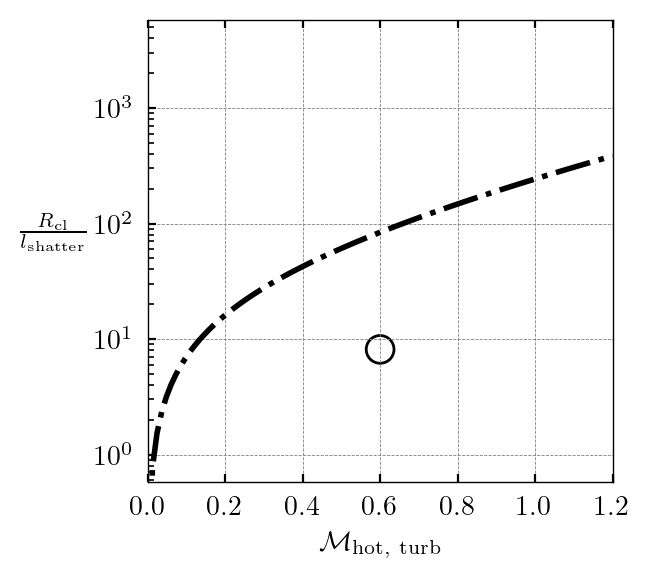

In [5]:
plot_point_bw(trial = '240610_0.6_8', verbose = False)

# Color plot

## Add params

In [6]:
# add the params to file
def save_params(trial, trial_x_val, trial_y_val, rp, l_shatter_min, log_mass_frac, t_cool_mix, t_cool_min, csvpath=f'/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e3.csv'):
    import pandas as pd
    df = pd.read_csv(csvpath, index_col=False, comment='#')
    # display(df)
    
    params_dict = {
        'trial' : trial,
        'x_mach' : trial_x_val,
        'y' : trial_y_val,
        'r_cl' : rp['cloud_radius'],
        'l_shat' : l_shatter_min,
        'log_cloud_mass' : log_mass_frac[-1],
        'T_cloud' : rp['T_cloud'],
        'T_floor' : rp['T_floor'],
        'chi' : rp['chi'],
        't_cool_mix' : t_cool_mix,
        't_cool_min' : t_cool_min,
    }
    
    # save trial in csv
    print(trial)
    if trial in list(df['trial']):  # if exists
        trial_ind = df.index[df['trial'] == trial][0]
        for col, val in params_dict.items():
            df.at[trial_ind, col] = val
    else:  # if no row with trial name, make one
        new_row = pd.DataFrame(params_dict, index=[0])
        df = pd.concat([df, new_row], ignore_index=True)
    
    # save updated csv
    display(df)
    df.to_csv(csvpath, index=False)

{'trial': '240610_0.6_8', 'cloud_flag': True, 'T_cloud': 8000.0, 'cloud_radius': 2e-05, 'cloud_pos': [0, 0, 0], 'box_size': 0.0004, 'grid_dim': 128, 'grid_vol': 2097152, 'grid_mesh': 32, 'T_floor': 8000.0, 'T_cold': 8000.0, 'T_ceil': 100000000.0, 'cooling_flag': True, 'T_hot': 4000000.0, 'rho_hot': 0.1, 'mach': 0.6, 'T_cut': 1000000.0, 'chi': 500.0, 'P_hot': 8.438675409534824e-14, 'v_turb': 0.1865317171670572, 't_eddy': 0.002144407428800762, 'cs_hot': 0.31088619527842865, 'T_mix': 178885.43819998318, 'T_warm': 178885.43819998318, 'dedt': 5.192159816942885e-11, 't_corr': 0.002144407428800762, 'dt_drive': 2.144407428800762e-06, 't_cc': 0.002397520391127022, 't_maxc': 0.002397520391127022, 'time_start': 0.02397520391127022, 'time_end': 0.04795040782254044, 'dt_hdf5': 0.0002397520391127022, 'time_cloud': 0.02397520391127022}
T_cold = 8000.0
T_hot = 4.00e+06
T_mix = 2.62e+05
t_cool,mix,og = 3.08e-03
t_cool,mix = 7.05e-03
t_cool,cold = 1.01e-01
t_cool_min = 1.21e-04
l_shatter_min = 2.46e-06


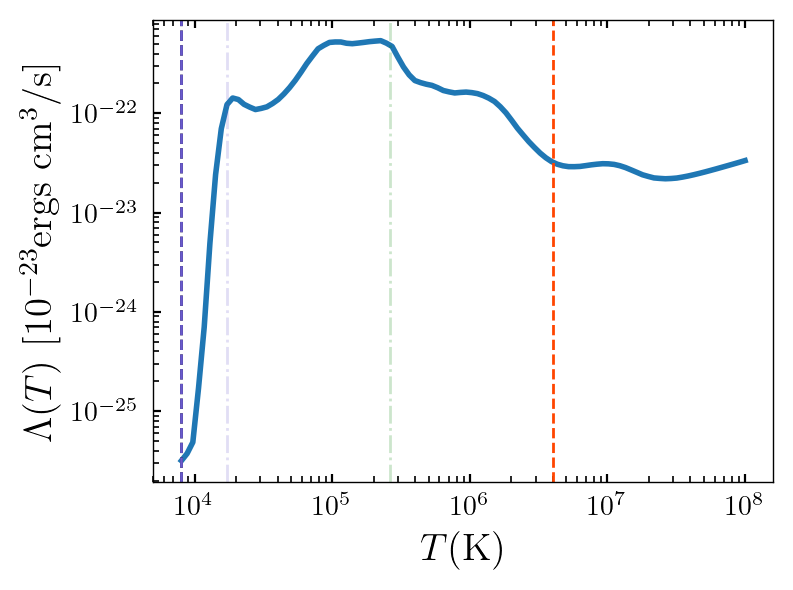

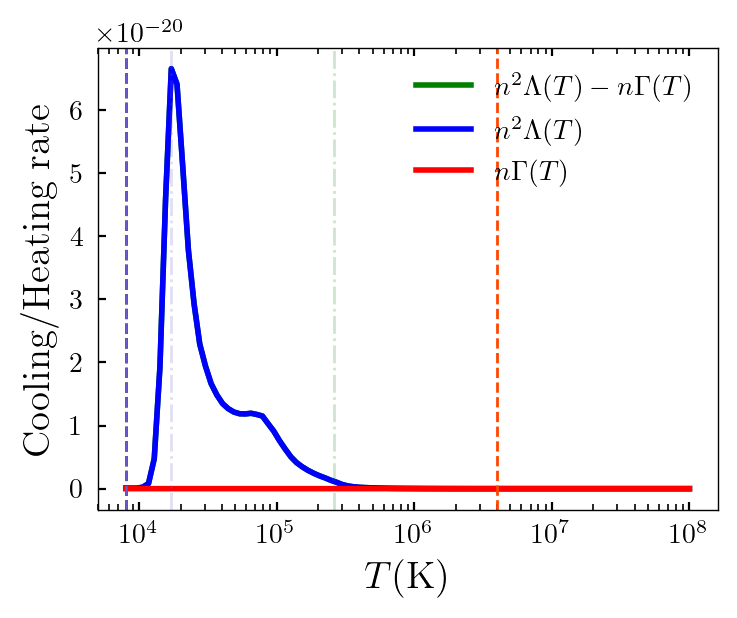

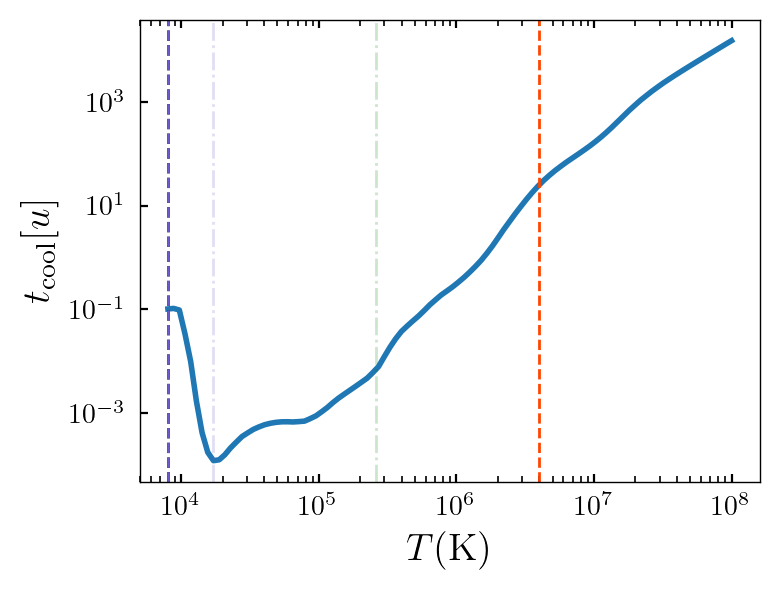

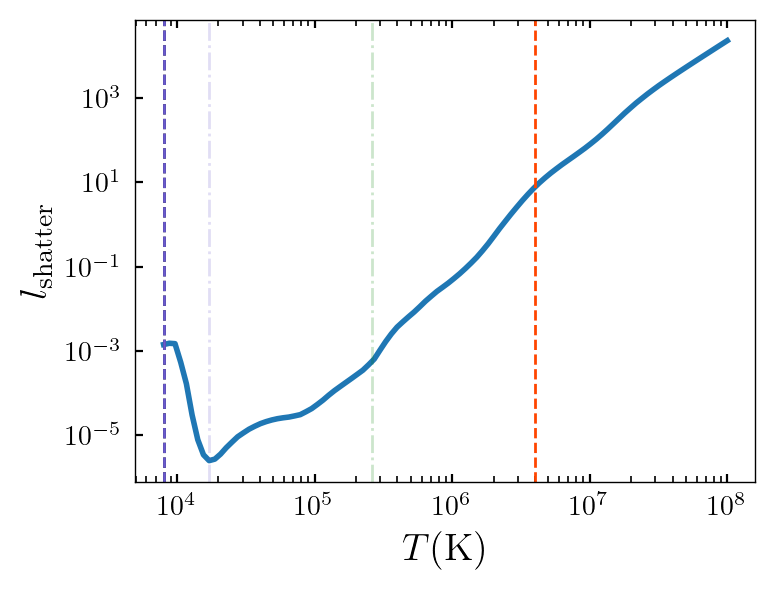

X-value = 0.6
Y-value [log] = 0.910
Y-value = 8.128
0.6 8.12827254707788
0.6 8.12827254707788
0.6 8.12827254707788
[1.26273e-13 1.51350e-13 1.63020e-13 ... 0.00000e+00 0.00000e+00
 2.00782e-12]


/tmp/ipykernel_7709/3425330071.py:202: RuntimeWarning: divide by zero encountered in log10
  log_mass_frac = np.log10(dataf['cold_gas'] / dataf['cold_gas'][cg_st_epoch])


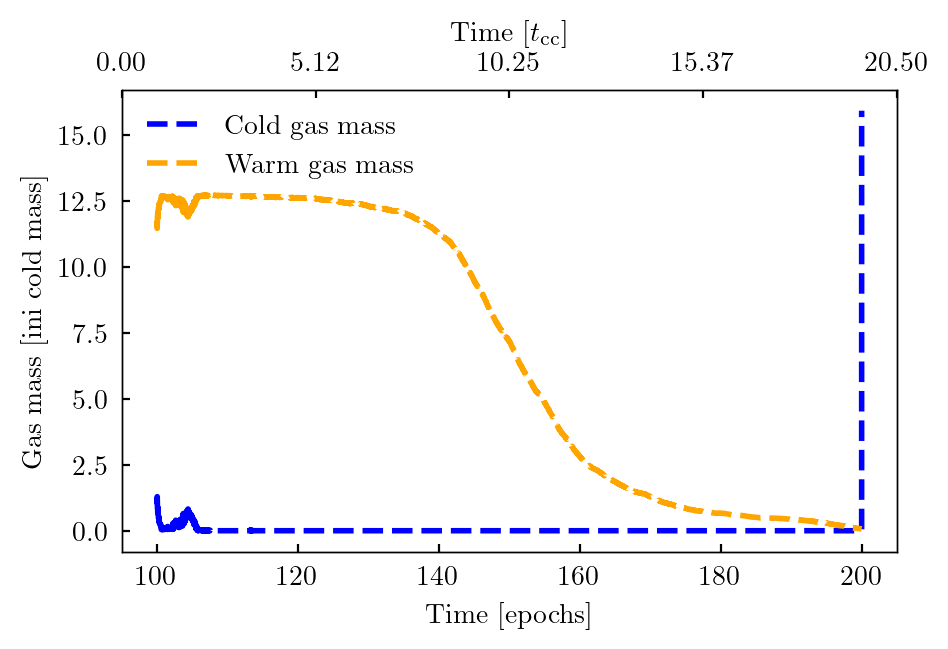

/tmp/ipykernel_7709/3425330071.py:262: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


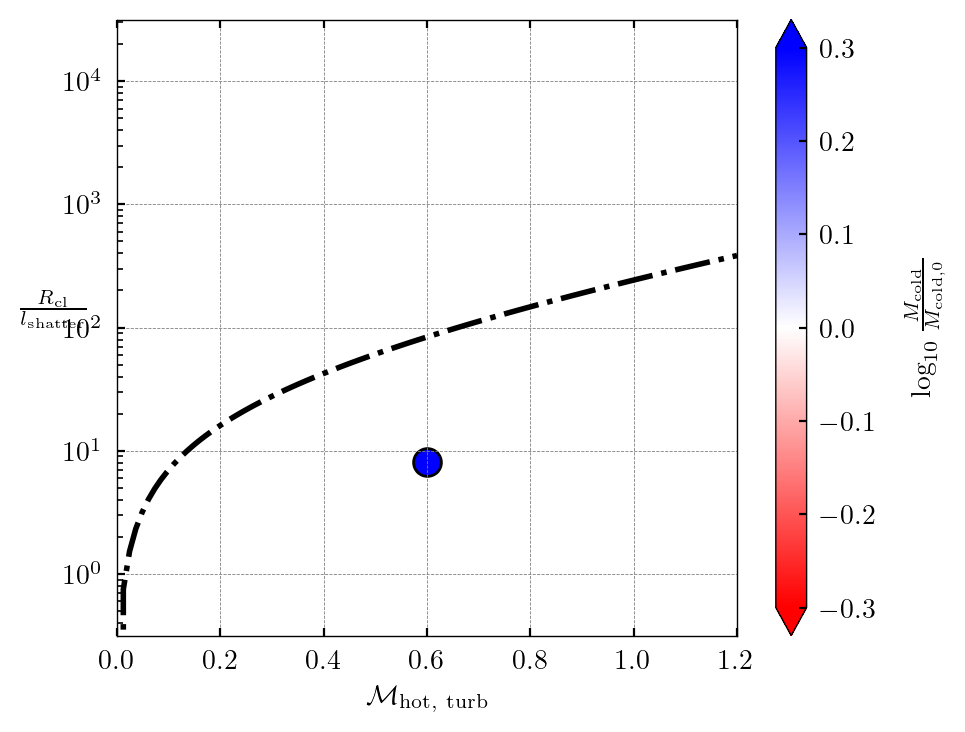

In [7]:
trial, trial_x_val, trial_y_val, rp, l_shatter_min, log_mass_frac, t_cool_mix, t_cool_min =\
plot_point_color(trial = '240610_0.6_8', verbose = True, cg_st_epoch = 0)

In [8]:
save_params(trial, trial_x_val, trial_y_val, rp, l_shatter_min, log_mass_frac, t_cool_mix, t_cool_min, csvpath=f'/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e3.csv')

240610_0.6_8


,trial,x_mach,y,r_cl,l_shat,log_cloud_mass,T_cloud,T_floor,chi,t_cool_mix,t_cool_min
0,240610_0.6_8,0.6,8.128273,0.000020,0.000002,1.201414,8000.0,8000.0,500.0,0.007048,0.000121
1,240610_0.6_2032,0.6,2032.068137,0.005000,0.000002,0.150000,8000.0,8000.0,500.0,0.063260,0.000121
2,240612_0.6_120,0.6,121.924088,0.000300,0.000002,-1.000000,8000.0,8000.0,500.0,0.063260,0.000121
3,240612_0.5_100,0.5,101.603407,0.000250,0.000002,-1.000000,8000.0,8000.0,500.0,0.063260,0.000121
4,240612_0.5_4,0.5,4.064136,0.000010,0.000002,-0.080534,8000.0,8000.0,500.0,0.063260,0.000121
5,240612_0.3_40,0.3,40.641363,0.000100,0.000002,-1.000000,8000.0,8000.0,500.0,0.063260,0.000121
6,240612_0.3_3,0.3,3.251309,0.000008,0.000002,-0.017615,8000.0,8000.0,500.0,0.063260,0.000121
7,240612_0.8_120,0.8,203.206814,0.000500,0.000002,-1.000000,8000.0,8000.0,500.0,0.063260,0.000121
8,240612_0.8_12,0.8,20.320681,0.000050,0.000002,-1.000000,8000.0,8000.0,500.0,0.063260,0.000121
9,240612_0.3_400,0.3,406.413627,0.001000,0.000002,0.102914,8000.0,8000.0,500.0,0.063260,0.000121


# All params

In [9]:
def plot_params_all(csvpath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e3.csv'):
    import pandas as pd
    df = pd.read_csv(csvpath, comment='#')
    
    all_x = df['x_mach'].to_numpy()
    all_y = df['y'].to_numpy()
    all_color = df['log_cloud_mass'].to_numpy()
    
    # set cloud and floor temperature text
    if df['T_cloud'][0] == 8e3:
        text_T_cloud = r'$T_{\rm cloud} = 8\times 10^3$'
    elif df['T_cloud'][0] == 4e4:
        text_T_cloud = r'$T_{\rm cloud} = 4\times 10^4$'
    elif df['T_cloud'][0] == 8e2:
        text_T_cloud = r'$T_{\rm cloud} = 8\times 10^2$'
    
    if df['T_floor'][0] == 8e3:
        text_T_floor = r'$T_{\rm floor} = 8\times 10^3$'
    elif df['T_floor'][0] == 4e4:
        text_T_floor = r'$T_{\rm cloud} = 4\times 10^4$'
    elif df['T_floor'][0] == 8e2:
        text_T_floor = r'$T_{\rm cloud} = 8\times 10^2$'
    text_T_cold = r'$T_{\rm cold} = 1.6\times 10^4$'

    plt.subplots(figsize=(5,4))
    cm = plt.colormaps['bwr_r']
    
    # scale the fraction
    all_color = np.clip(all_color, -1, 1)
    
    # scatter the points
    sc = plt.scatter(all_x, all_y, marker='o',
                     c=all_color, vmin=-0.3, vmax=0.3, ec='k', cmap=cm)
    
    # annotate with its color value
    for i in range(len(all_x)):
        col = all_color[i]
        if col == 1: col = np.inf
        elif col == -1: col = -np.inf
        col = f'{col:.2f}'.replace('-', '\N{MINUS SIGN}')
        plt.text(all_x[i] + 0.05, all_y[i], col, fontsize=8, ha='left', va='center')
    
    
    # label the temperatures
    plt.text(1., 1e0, text_T_cloud, fontsize=10, ha='center', va='center')
    plt.text(1., 5e-1, text_T_floor, fontsize=10, ha='center', va='center')
    plt.text(1., 2e0, text_T_cold, fontsize=10, ha='center', va='center')
    
    # analytical line
    ana_x = np.linspace(0, 1.2, 100)
    ana_y = ana_x * df['t_cool_mix'][0] / df['t_cool_min'][0] * 10. ** (0.6 * ana_x + 0.02)
    plt.plot(ana_x, ana_y, ls='-.', color='k')
    
    # axis
    plt.xlim(0, 1.2)
    plt.ylim(np.power(10., -0.5), np.power(10., 4.5))
    plt.yscale('log')
    plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
    plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0)
    
    # color bar
    cbar = plt.colorbar(sc, extend='both')
    cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
    plt.legend()
    plt.grid()
    plt.show()

/tmp/ipykernel_7709/3703578102.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


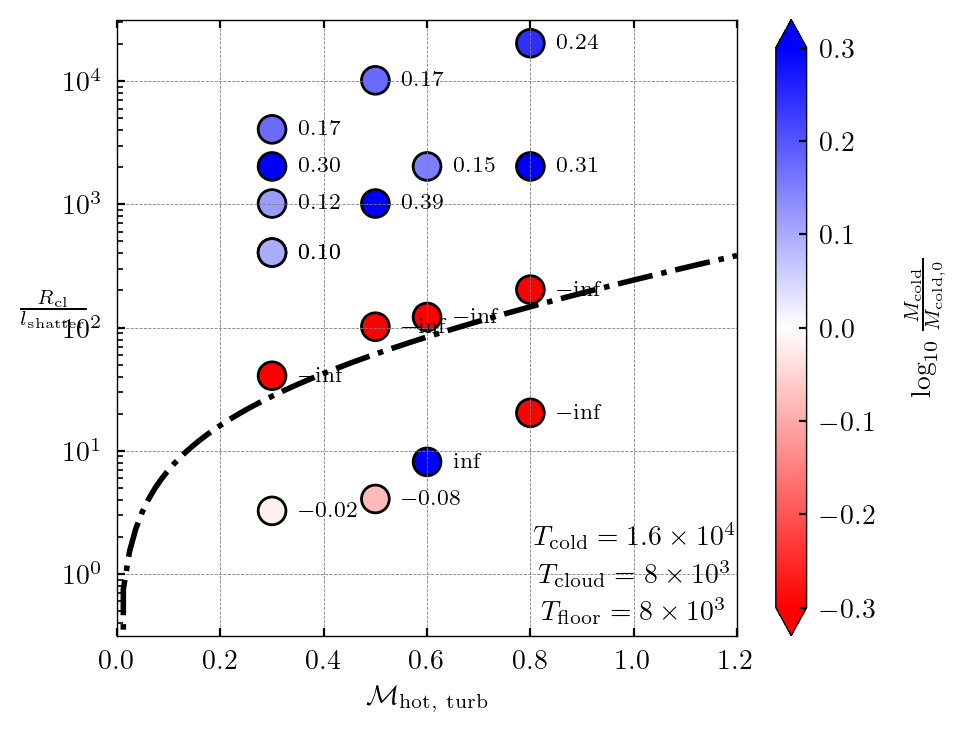

In [10]:
plot_params_all(csvpath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e3.csv')

# All params from file

In [17]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import matplotlib.patheffects as pe
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle

import cmasher as cmr

cm_cold = cmr.get_sub_cmap('cmr.viola_r', 0.25, 0.75)  #plt.colormaps['bwr_r']  # diverging colormap for cold gas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def plot_params_all_file(csvpath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e3.csv',
                         cg_st_epoch = 0,
                         verbose = False):
    # load the trials
    import pandas as pd
    df = pd.read_csv(csvpath, comment='#')
    trials = df['trial'].to_numpy()

    # initialize the plot
    fig, ax = plt.subplots(figsize=(4,4))
    # make the plot
    cm = cm_cold#plt.colormaps['bwr_r']

    # set cloud and floor temperature text
    if df['T_cloud'][0] == 8e3:
        text_T_cloud = r'$T_{\rm cloud} = 8\times 10^3$'
    elif df['T_cloud'][0] == 4e4:
        text_T_cloud = r'$T_{\rm cloud} = 4\times 10^4$'
    elif df['T_cloud'][0] == 8e2:
        text_T_cloud = r'$T_{\rm cloud} = 8\times 10^2$'
    
    if df['T_floor'][0] == 8e3:
        text_T_floor = r'$T_{\rm floor} = 8\times 10^3$'
    elif df['T_floor'][0] == 4e4:
        text_T_floor = r'$T_{\rm cloud} = 4\times 10^4$'
    elif df['T_floor'][0] == 8e2:
        text_T_floor = r'$T_{\rm cloud} = 8\times 10^2$'
    text_T_cold = r'$T_{\rm cold} = 1.6\times 10^4$'
    
    for trial in trials:
        rp, x, y, t_cool_mix, t_cool_min, t_cool_cold = add_point(trial=trial, verbose=verbose)
        # print(t_cool_mix, t_cool_min, t_cool_cold)
        # correct for bad trials
        if trial in ['240612_0.5_1000', '240612_0.8_1200']:
            x = 0.3
        log_cold_frac = add_color(rp=rp, trial=trial, verbose=verbose, cg_st_epoch=cg_st_epoch)
        # normalize for all fractions
        log_frac = np.nan_to_num(log_cold_frac, posinf=1, neginf=-1)
        
        """Plot both cold gas plots"""
        # find the stable points
        t_cc_lim = 2  # when is the point stable
        stable_ind = int(np.ceil(t_cc_lim * rp['t_cc'] / rp['dt_hdf5']))
        log_frac_stable = log_frac[stable_ind:]  # select all points onward
        
        # take the mean and the std
        log_frac_mean = np.clip(np.mean(log_frac_stable), -0.5, 1)
        
        # scatter the points
        sc = ax.scatter(x, y, marker='o',
                        c=log_frac_mean, vmin=-0.3, vmax=0.3, ec='k', cmap=cm)

        col = log_frac_mean
        if np.isclose(col, -.5): col = -np.inf  # catchs only the cold values
        col = f'{col:.2f}'.replace('-', '\N{MINUS SIGN}')
        plt.text(x + 0.05, y, col, fontsize=8, ha='left', va='center')
        
    # analytical line
    ana_x = np.linspace(0, 1.2, 100)
    # og ana
    ana_y = ana_x * (t_cool_mix) / t_cool_min * 10. ** (0.6 * ana_x + 0.02) / 1.5
    # ax.plot(ana_x, ana_y, ls='-.', color='k', alpha=0.5)
    # new ana
    print(t_cool_cold, t_cool_min)
    ana_y = ana_x * (t_cool_cold) / t_cool_min * 10. ** (0.6 * ana_x) / 1.5
    ax.plot(ana_x, ana_y, ls='-.', lw=1, color='k', alpha=0.5)


    # label the temperatures
    # ax.text(1., 1e0, text_T_cloud, fontsize=10, ha='center', va='center')
    # ax.text(1., 5e-1, text_T_floor, fontsize=10, ha='center', va='center')
    # ax.text(1., 2e0, text_T_cold, fontsize=10, ha='center', va='center')
    
    # axis
    ax.set_xlim(0.18, 1.02)
    ax.set_ylim(np.power(10., 0), np.power(10., 5))
    ax.set_yscale('log')
    ax.set_xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
    ax.set_ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0, labelpad=14)
    ax.legend()
    # ax.grid()

    # add colorbar
    cbar_ax = fig.add_axes([0.915, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(sc, cax=cbar_ax, extend='both')
    # cbar1.set_ticklabels([])
    cbar.ax.set_xlabel('cold', ha='left', labelpad=10)
    cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=3)
    plt.show()
    return trial, x, y, rp, rp['cloud_radius'] / y, log_cold_frac, t_cool_mix, t_cool_min

0.10135343570552248 0.0001208881091945857


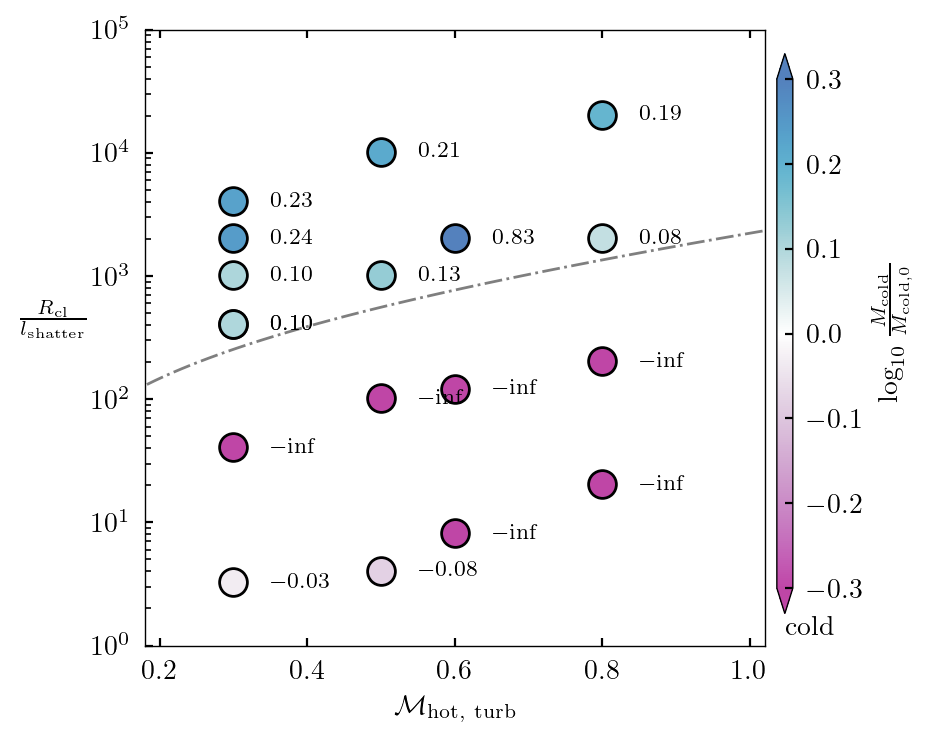

In [23]:
_ =\
plot_params_all_file(csvpath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e3.csv', cg_st_epoch=10)

# 800K runs

In [208]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import matplotlib.patheffects as pe
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle

import cmasher as cmr

    
def plot_params_coolmix_cc(csvpath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e2_old.csv',
                           cg_st_epoch = 0, log_ylimu = 9, ms = 30,
                           plot_ana = False, show_text = True,
                           cm = None, verbose = False):
    # load the trials
    from matplotlib.gridspec import GridSpec
    import pandas as pd
    df = pd.read_csv(csvpath, comment='#')
    trials = df['trial'].to_numpy()
    
    # extra parameters
    actual_mach = df['x_mach'].to_numpy()
    
    # initialize the plot
    fig, ax = plt.subplots(figsize=(5, 4))
    # make the markers
    marker = MarkerStyle("o")
    
    for i, trial in enumerate(trials):
        # load the hst file
        datapath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/{trial}'
        
        # try
        try:
            fname = f'{datapath}/turb/Turb.hst'
            with open(fname, 'r') as file: keys_raw = file.readlines()[1]
            keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
        except:
            fname = f'{datapath}/cloud/Turb.hst'
            with open(fname, 'r') as file: keys_raw = file.readlines()[1]
            keys = [a.split('=')[1] for a in keys_raw.split()[1:]]

        fname = f'{datapath}/cloud/Turb.hst'
        data = np.loadtxt(fname).T
        hst_data = {keys[i]: data[i] for i in range(len(keys))}

        """Get the data"""
        rp, x, y, t_cool_mix, t_cool_min, t_cool_cold = add_point(trial=trial, verbose=verbose)

        # replace x with actual mach
        if trial in ['240612_0.5_1000', '240612_0.8_1200']:
            x = 0.3
        log_cold_frac = add_color(rp=rp, trial=trial, verbose=verbose, cg_st_epoch=cg_st_epoch)

        # replace y with log10(t_cc / t_cool,mix)
        vturb = x * calc_cs(rp['T_hot'])
        t_cc = (rp['chi'] ** (1/2) * rp['cloud_radius'] / vturb)
        y = np.log10(t_cc / t_cool_cold)
        
        # normalize for all fractions
        log_frac = np.nan_to_num(log_cold_frac, posinf=1, neginf=-1)

        # plotting params from dataframe
        pt_size = ms
            
        # find the stable points
        t_cc_lim = 1  # when is the point stable
        stable_ind = int(np.ceil(t_cc_lim * rp['t_cc'] / (rp['dt_hdf5'] / 100)))  # normalize to hst time
        log_frac_stable = log_frac[stable_ind:]  # select all points onward, up to stable point
        
        # take the mean and the std
        log_frac_mean = np.clip(np.mean(log_frac_stable), -0.5, 1)
        
        # scatter the points
        sc = ax.scatter(x, y, marker=marker, s=pt_size, label='cold' if not i else None,
                        c=log_frac_mean, vmin=-0.3, vmax=0.3, ec='k', cmap=cm)
        
        # color label with text
        col = log_frac_mean
        if np.isclose(col, -.5): col = -np.inf  # catchs only the cold values
        col = f'{col:.1f}'.replace('-', '\N{MINUS SIGN}')

        if show_text:
            ax.text(x - 0.3 * np.sqrt(pt_size)/ms, y, col, fontsize=6, ha='center', va='center', path_effects=[pe.withStroke(linewidth=0.5, foreground="white")])
    
    # axis
    ax.set_xlim(0.2, 1)
    ax.set_ylim(-1, 3)
    ax.set_xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
    ax.set_ylabel(r'$\log_{10}(t_{\rm cc} / t_{\rm cool,mix})$', rotation=90)
    ax.legend(loc='best', frameon=True, fancybox=False, shadow=True)

    if plot_ana:
        ana_x = np.linspace(0, 1.2, 100)
        # ax.plot(ana_x, 0.6 * ana_x + 0.6368956101995327, color='blue', ls='-.', alpha=0.5, label='cold ana')
        ax.plot(ana_x, 0.6 * ana_x, color='gray', ls='-.', alpha=0.5, label='og')

    """color bar"""
    # cold
    cbar_ax1 = fig.add_axes([0.925, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar1 = plt.colorbar(sc, cax=cbar_ax1, extend='both')
    cbar1.set_ticklabels([])
    cbar1.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
    cbar1.ax.set_xlabel('c', labelpad=10)
    
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


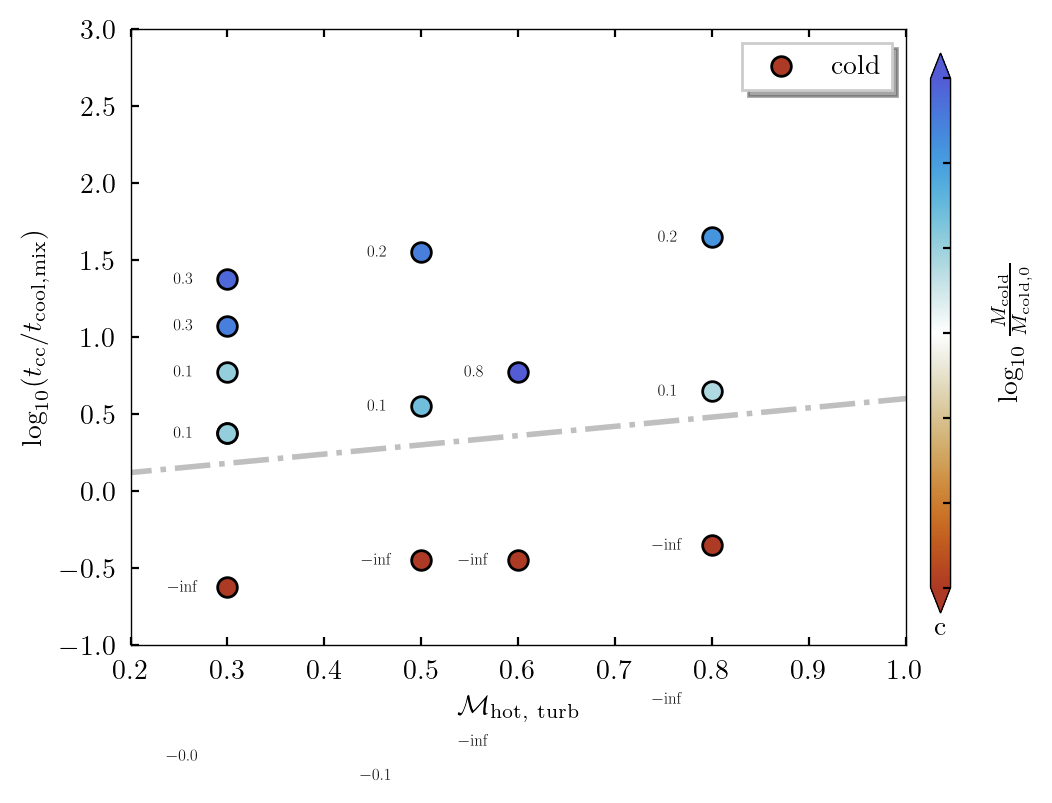

In [209]:
cm_cold = cmr.get_sub_cmap('cmr.fusion', 0.2, 0.8)
ms = 50

plot_params_coolmix_cc(csvpath='/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e3.csv',
                       cm=cm_cold, ms=ms,
                       plot_ana=True, show_text=True)

## Timescale plot

In [206]:
def plot_timescales(trial = '', verbose = False):
    datapath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/{trial}'
    with open(f'{datapath}/params.pickle', 'rb') as handle:
        rp = pickle.load(handle)

    # Import the cooling function from Hitesh's scripts
    import sys
    sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/multiphase_turb/athena/cooling_scripts'))
    import cooling_fn as cf
    sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/multiphase_turb/athena/helper_scripts'))
    import v_turb as vt

    # temperature range
    T_arr = np.logspace(np.log10(rp['T_floor']),
                        np.log10(rp['T_ceil']), 100)  # in kelvin
    rho_arr = rp['rho_hot'] * rp['T_hot'] / T_arr
    
    """
    Cooling & Heating functions
    """
    Gamma_n_arr = 1e-26 / rho_arr
    Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)
    
    """
    Cooling & Heating rates
    """
    heating_rate = 1e-26 * rho_arr
    cooling_rate = Lambda_arr * rho_arr**2
    
    """
    Timescale
    """
    tcool_arr = np.vectorize(cf.tcool_calc)(
        rho_arr, T_arr, Zsol=1.0, Lambda_fac=1.0, fit_type="max"
    )

    """
    Shattering length
    """
    def calc_cs(T):
        m_to_cm = 100
        return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) / u.unit_velocity
    t_cool_func = lambda T : cf.tcool_calc(rp['rho_hot'] * rp['T_hot'] / T, T, Zsol=1.0, Lambda_fac=1.0, fit_type="max")
    l_shatter = np.vectorize(t_cool_func)(T_arr) * calc_cs(T_arr)

    """
    Minimum l_shatter
    """
    # calculate geometric mean T_mix
    # the two limits
    T_cold = rp['T_cloud']  # set cold temperature to that of cloud
    T_hot = rp['T_hot']

    """T_mix calculations"""
    # the params in range
    T_ind_low, T_ind_high = find_ind_l(T_arr, T_cold), find_ind_l(T_arr, T_hot)
    T_range = T_arr[T_ind_low : T_ind_high]
    tcool_range = tcool_arr[T_ind_low : T_ind_high]
    
    T_tcoolmin = T_range[np.argmin(tcool_range)]  # the temperature corresponding to the lowest t_cool
    T_mix = np.sqrt(T_tcoolmin * T_hot)  # use the temperature at which t_cool is lowest instead of this:  # T_mix = np.sqrt(T_cold * T_hot)  # use the cloud temperature

    t_cool_min = np.min(tcool_range)
    t_cool_mix = t_cool_func(T_mix)
    t_cool_cold = t_cool_func(T_cold)
    
    l_shatter_min = np.min(l_shatter[T_ind_low : T_ind_high])

    if verbose:
        print(f'T_cold = {T_cold}')
        print(f'T_hot = {T_hot:.2e}')
        print(f'T_mix = {T_mix:.2e}')
        print(f't_cool,mix,og = {t_cool_func(np.sqrt(T_cold * T_hot)):.2e}')
        print(f't_cool,mix = {t_cool_mix:.2e}')
        print(f't_cool,cold = {t_cool_cold:.2e}')
        print(f't_cool_min = {t_cool_min:.2e}')
        print(f'l_shatter_min = {l_shatter_min:.2e}')
    
    def plot_tvlines():
        plt.axvline(x=rp['T_floor'], lw=1, color="k", linestyle="--")
        plt.axvline(x=rp['T_cloud'], lw=1, color="slateblue", linestyle="--")
        plt.axvline(x=T_tcoolmin, lw=1, color="slateblue", linestyle="-.", alpha=0.2)
        plt.axvline(x=T_mix, lw=1, color="green", linestyle="-.", alpha=0.2)
        plt.axvline(x=rp['T_hot'], lw=1, color="orangered", linestyle="--")
        # plt.axvline(x=T_cut color="k", linestyle="")
    
    """Cooling timescale"""
    plt.figure(figsize=(4, 3))
    
    plt.plot(T_arr, tcool_arr, label=r"$\Lambda(T)$")
    plt.ylabel(r"$t_{\rm cool} [u]$", fontsize=14)
    plt.xlabel(r"$T$(K)", fontsize=14)
    plt.yscale("log")
    plt.xscale("log")
    plot_tvlines()
    # plot the t_cc intersection lines
    T_actual = T_arr[-find_ind_l(-tcool_arr[::-1], -rp['t_cc'])]
    ratio_actual = T_actual / T_mix
    print(f'T_actual = {T_actual:.3e}, ratio = {ratio_actual}')
    plt.axhline(rp['t_cc'], ls='--', lw=1, c='k', alpha=0.3, label=r'$t_{\rm cc}$')
    plt.axvline(T_actual, ls='--', lw=1, c='k', alpha=0.3)
    plt.text(1e8, rp['t_cc'] * 2, r'$t_{\rm cc}$', c='k', alpha=0.8, ha='right', va='bottom')
    plt.show()

    return T_actual, ratio_actual

T_actual = 3.979e+05, ratio = 1.5194394097756962


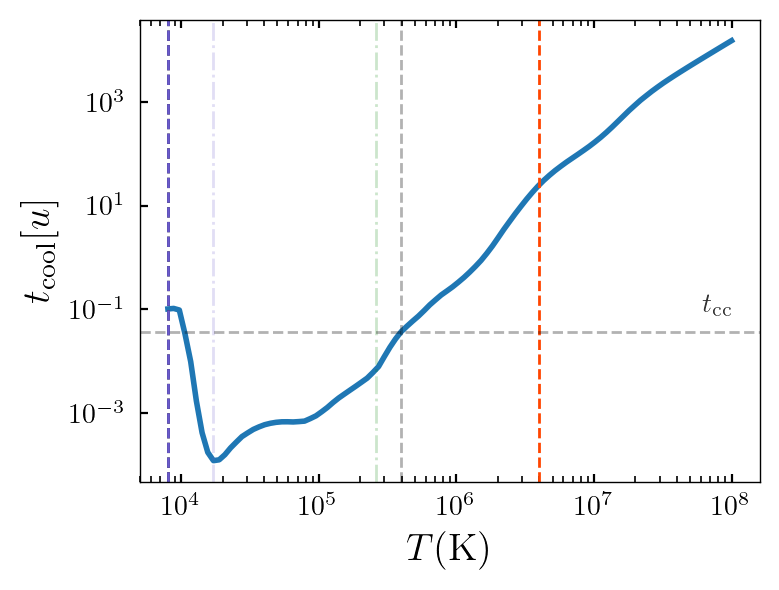

In [207]:
# destroyed
_, ratio =\
plot_timescales('240612_0.6_120', verbose=False)

T_actual = 1.373e+06, ratio = 5.243985341630283


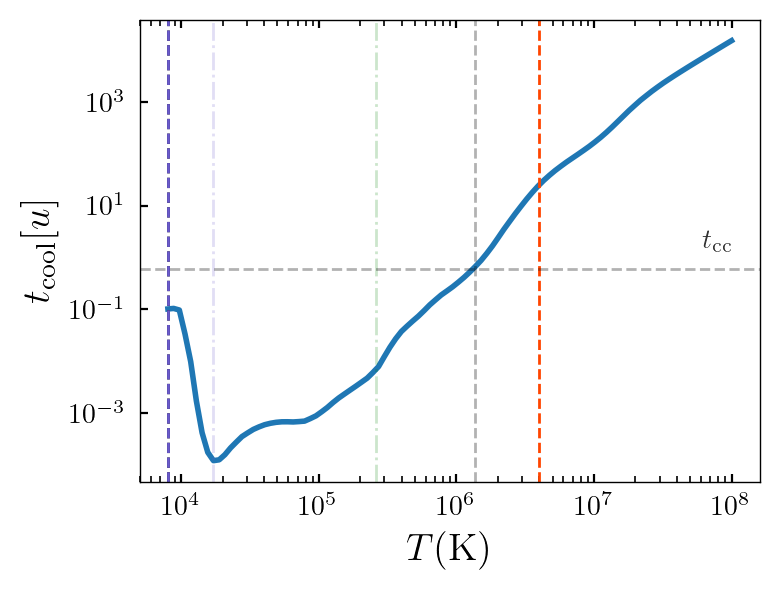

In [201]:
# survives
_, ratio =\
plot_timescales('240610_0.6_2032', verbose=False)

In [197]:
np.log10(ratio)

0.6168956101995327

# Cloud evol plot

## Growth rate estimate

In [8]:
def plot_exp_growth_rate(ax, time_arr_eddy, csvpath = '/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e3.csv', mach = 0.3, alpha = 0.5):
    import pandas as pd
    df = pd.read_csv(csvpath, comment='#')
    df['yval'] = df["r_cl"] / df["l_shat"]
    df.sort_values(by='yval', inplace=True)
    xys, cs = [], []
    fig, ax1 = plt.subplots(figsize=(5,3))
    cm = plt.colormaps['BrBG_r']  # colormap for the gas fractions
    
    for _, row in df.iterrows():
        if row['x_mach'] != mach:
            continue
        datapath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/{row['trial']}'

        # load run parameters
        with open(f'{datapath}/params.pickle', 'rb') as handle:
            rp = pickle.load(handle)
    
        # load t_cool_min
        l_shatter_min, t_cool_mix, t_cool_min = load_lshat(rp=rp, verbose=False)

        # growth time
        t_grow = alpha * rp['chi'] *\
        (rp['mach'] ** -1/2) *\
        (df['yval'] ** 1/2) *\
        (rp['box_size'] / rp['cloud_radius'] ** 1/6) *\
        t_cool_min

        # time_arr in eddie time
        time_arr = time_arr_eddy
        cold_frac = np.exp(time_arr / t_cool_min)
        ax.plot(time_arr_eddy, cold_frac, lw=1, ls='-.', alpha=0.2, color='k')

## Basic

In [9]:
def plot_evol_all(csvpath = '/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e3.csv', mach = 0.3, alpha = 0.5, verbose = False, plot_growth = False):
    from matplotlib.collections import LineCollection
    import pandas as pd
    df = pd.read_csv(csvpath, comment='#')
    df['yval'] = df["r_cl"] / df["l_shat"]
    df.sort_values(by='yval', inplace=True)
    xys, cs = [], []
    fig, ax1 = plt.subplots(figsize=(5,3))
    cm = plt.colormaps['BrBG_r']  # colormap for the gas fractions
    
    for _, row in df.iterrows():
        if row['x_mach'] != mach:
            continue
        datapath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/{row['trial']}'
        
        """Load history file"""
        # try
        try:
            fname = f'{datapath}/turb/Turb.hst'
            with open(fname, 'r') as file: keys_raw = file.readlines()[1]
            keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
        except:
            fname = f'{datapath}/cloud/Turb.hst'
            with open(fname, 'r') as file: keys_raw = file.readlines()[1]
            keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
        
        fname = f'{datapath}/cloud/Turb.hst'
        data = np.loadtxt(fname).T
        dataf = {keys[i]: data[i] for i in range(len(keys))}
        # cold gas
        cg = dataf['cold_gas']
        cg_st_epoch = (cg != 0).argmax()
        
        log_mass_frac = row['log_cloud_mass']#np.log10(cg[-1] / cg[cg_st_epoch])
    
        """Load run parameters"""
        with open(f'{datapath}/params.pickle', 'rb') as handle:
            rp = pickle.load(handle)
    
        x = dataf['time'] / rp['t_eddy']
        y = dataf['cold_gas'] / dataf['cold_gas'][cg_st_epoch]
        color = cm(plt.Normalize(0, 3)(np.log10(row["yval"])))
        ax1.plot(x, y, lw=1, ls='-', color=color, alpha=0.5, label=fr'$R/l_{{\rm shatter}} = {row["yval"]:.0f}$')


        """Plot all expected growths"""
        if plot_growth:
            # load t_cool_min
            l_shatter_min, t_cool_mix, t_cool_min = load_lshat(rp=rp, verbose=verbose)
    
            # growth time
            t_grow = alpha * rp['chi'] *\
            (rp['mach'] ** (-1/2)) *\
            (row['yval'] ** (1/2)) *\
            ((rp['box_size'] / rp['cloud_radius']) ** (1/6)) *\
            t_cool_min
    
            # use actual time, plot eddie time
            print(alpha, rp['chi'], rp['mach'], row['yval'], rp['box_size'] / rp['cloud_radius'])
            print(t_grow, rp['t_eddy'], t_cool_min)
            cold_frac = np.exp(dataf['time'] / t_grow)
            ax1.plot(x, cold_frac, lw=1, ls='-.', alpha=0.2, color=color)

    # y axis
    ax1.set_ylim(1/3, 3)
    ax1.set_yscale('log')
    ax1.set_ylabel(r'$M_{\rm cold} / M_{\rm cold, ini}$')
    
    # x axis
    ax1.set_xlim(0, 2)
    ax1.set_xlabel(r"Time $t / t_{\rm eddy}$")
    
    ax1.legend(loc='lower right', bbox_to_anchor=(1.8, 0.1), fontsize=10, alignment='center')
    sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(0, 3))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax1)
    cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
    plt.title(fr'${{\mathcal{{M}} = {mach}}}$, resolution: $128^3$')
    plt.show()

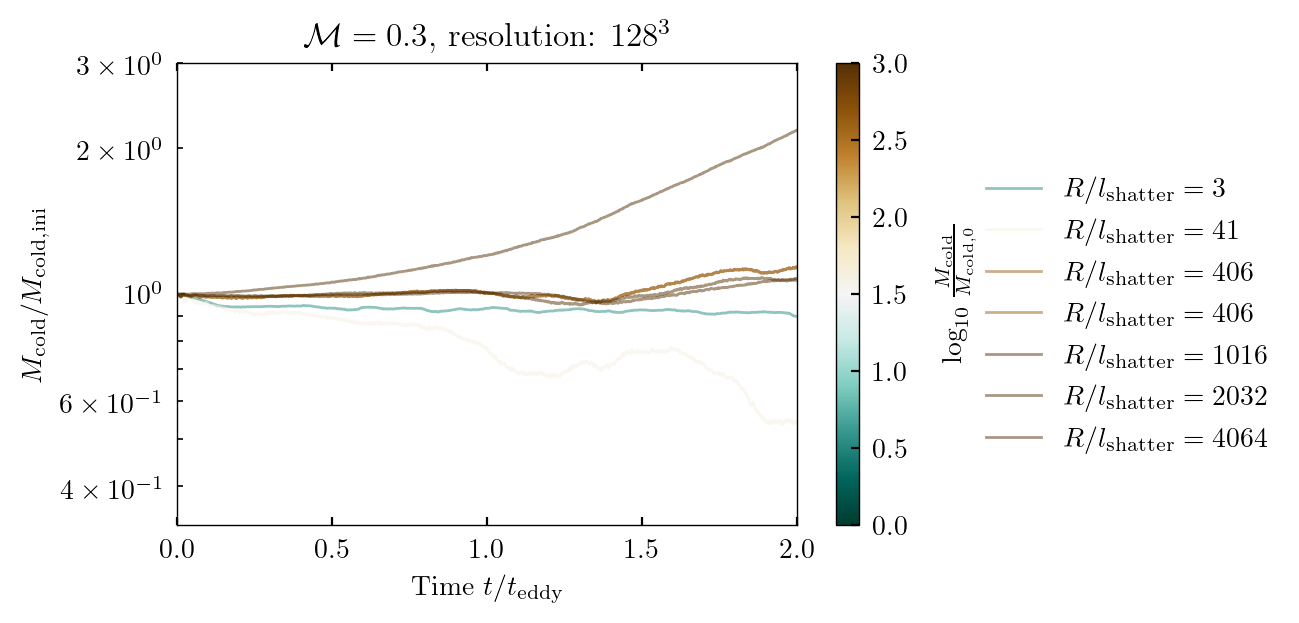

In [10]:
plot_evol_all(mach=0.3, verbose=False)

## With different cold gas temperatures

In [27]:
def plot_evol_all_ratio(csvpath = '/freya/ptmp/mpa/wuze/multiphase_turb/data/saves/cloud_8e3.csv', mach = 0.3, cold_cloud_ratio = 2, plot_wg = True):
    """
    PARAMS
    -----
    mach: only plot the points for a certain mach number
    cold_cloud_ratio: the ratio between cloud temperature and cold gas temperature criteria
        Choose within cold_cloud_ratio_list = [2, 3, 5, 10]
    """
    from matplotlib.collections import LineCollection
    import pandas as pd
    import pickle
    df = pd.read_csv(csvpath, comment='#')
    df['yval'] = df["r_cl"] / df["l_shat"]
    df.sort_values(by='yval', inplace=True)
    xys, cs = [], []
    fig, ax1 = plt.subplots(figsize=(5,3))
    fig, ax2 = plt.subplots(figsize=(5,3))
    cm = plt.colormaps['BrBG_r']  # colormap for the gas fractions

    x_lims = []
    for _, row in df.iterrows():
        if row['x_mach'] != mach:
            continue
        datapath = f'/freya/ptmp/mpa/wuze/multiphase_turb/data/{row['trial']}'
        
        """Load history and temperatures"""
        with open(f'{datapath}/cloud/time_temperature', 'rb') as handle:
            time_athdf, temperature_athdf, mass_athdf = pickle.load(handle)
    
        """Load run parameters"""
        with open(f'{datapath}/params.pickle', 'rb') as handle:
            rp = pickle.load(handle)

        """Gas masses"""
        # cold gas mass
        T_cold = rp['T_cloud'] * cold_cloud_ratio
        cg = []  # cold gas mass array
        # warm gas mass
        T_warm = rp['T_warm']
        wg = []
        
        for temp_arr, mass_arr in zip(temperature_athdf, mass_athdf):
            cg_epoch = np.sum(mass_arr[temp_arr <= T_cold])
            cg.append(cg_epoch)  # append the cold gas mass for one time save
            if plot_wg: wg.append(np.sum(mass_arr[np.logical_and(temp_arr > T_cold, temp_arr <= T_warm)]))

            # check for 1/3 box size
            if cg_epoch > np.sum(mass_arr) / 3:
                break
                
        cg = np.array(cg); wg = np.array(wg)
        cg_st_epoch = (cg != 0).argmax()
        # calculate mass fractional manually
        log_mass_frac = np.log10(cg[-1] / cg[cg_st_epoch])

        # mass evolution
        x = time_athdf / rp['t_eddy']  # in units of t_eddy
        y_cg = cg / cg[cg_st_epoch]
        y_wg = wg / cg[cg_st_epoch]
        color = cm(plt.Normalize(0, 3)(np.log10(row["yval"])))

        # limit to 1/3 box mass
        x = x[:len(y_cg)]
        x_lims.append(np.max(x))
        ax1.plot(x, y_cg, lw=1, ls='-', color=color, alpha=0.5, label=fr'$R/l_{{\rm shatter}} = {row["yval"]:.0f}$')
        if plot_wg: ax2.plot(x, y_wg, lw=1, ls='-', color=color, alpha=0.5, label=fr'$R/l_{{\rm shatter}} = {row["yval"]:.0f}$')
    
    # y axis
    ax1.set_ylim(1/3, 3)
    ax1.set_yscale('log')
    ax1.set_ylabel(r'$M_{\rm cold} / M_{\rm cold, ini}$')
    
    # x axis
    # plot to 1/3 of the box mass, whichever trial has the minimum
    ax1.set_xlim(0, np.min(x_lims))
    ax1.set_xlabel(r"Time $t / t_{\rm eddy}$")
    
    ax1.text(0.5, 2e0, fr'$T_{{\rm cold}} = {T_cold:.0f}$', ha='center')
    
    ax1.legend(loc='lower right', bbox_to_anchor=(1.8,0.1), fontsize=10, alignment='center')
    sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(0, 3))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax1)
    cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
    plt.title(fr'${{\mathcal{{M}} = {mach}}}$, resolution: $128^3$')

    if plot_wg:
        ax2.set_ylim(1e-4, 1)
        ax2.set_yscale('log')
        ax2.set_ylabel(r'$M_{\rm warm} / M_{\rm cold, ini}$')
        ax2.set_xlim(0, np.min(x_lims))
        ax2.set_xlabel(r"Time $t / t_{\rm eddy}$")
        ax2.legend(loc='lower right', bbox_to_anchor=(1.3,0.1), fontsize=10, alignment='center')

    plt.show()

24000.0 178885.43819998318
24000.0 178885.43819998318


/tmp/ipykernel_9816/1256367879.py:55: RuntimeWarning: divide by zero encountered in log10
  log_mass_frac = np.log10(cg[-1] / cg[cg_st_epoch])


24000.0 178885.43819998318
24000.0 178885.43819998318
24000.0 178885.43819998318
24000.0 178885.43819998318
24000.0 178885.43819998318


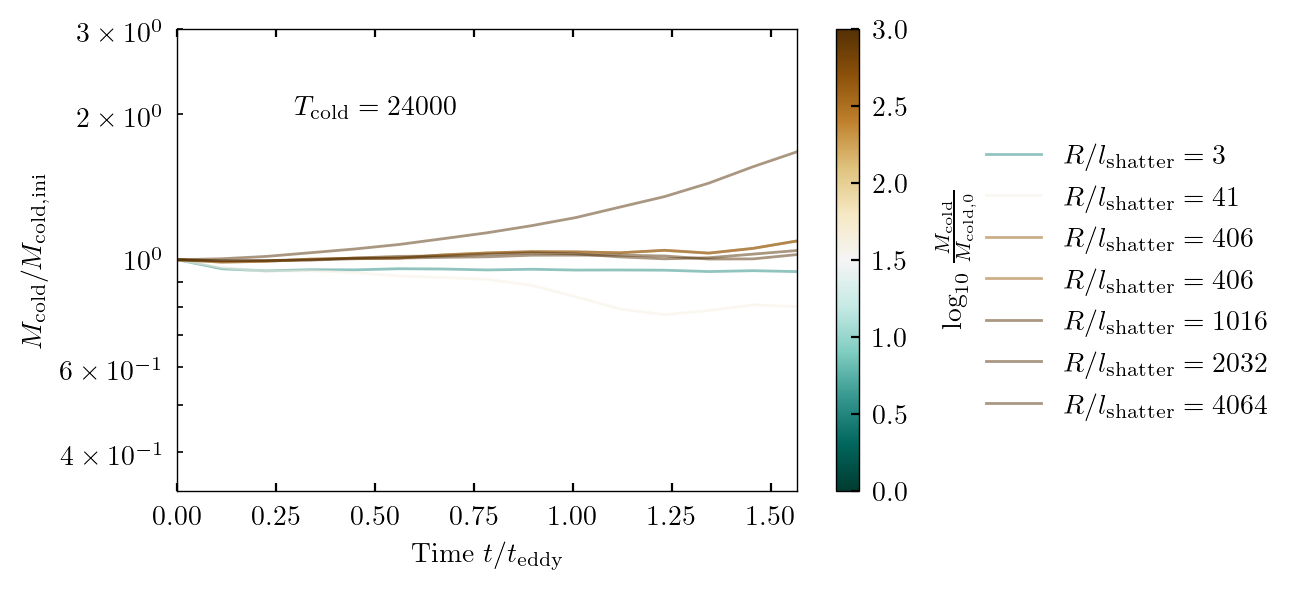

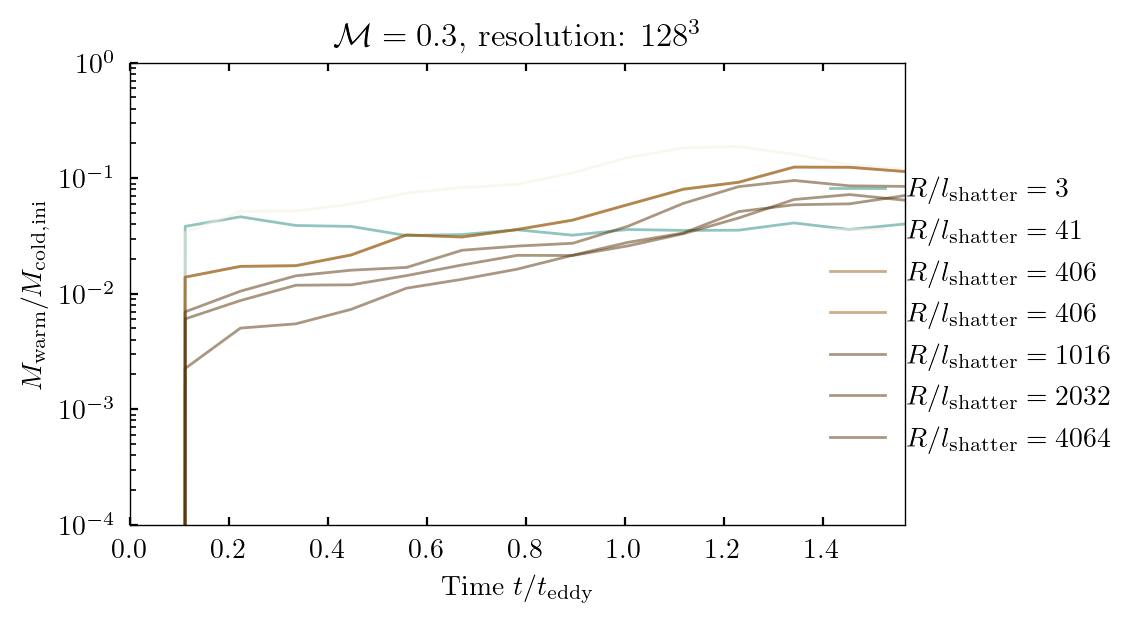

In [28]:
# Choose within cold_cloud_ratio_list = [2, 3, 5, 10]
plot_evol_all_ratio(mach=0.3, cold_cloud_ratio=3)

24000.0 178885.43819998318
24000.0 178885.43819998318


/tmp/ipykernel_9816/1256367879.py:55: RuntimeWarning: divide by zero encountered in log10
  log_mass_frac = np.log10(cg[-1] / cg[cg_st_epoch])


24000.0 178885.43819998318
24000.0 178885.43819998318


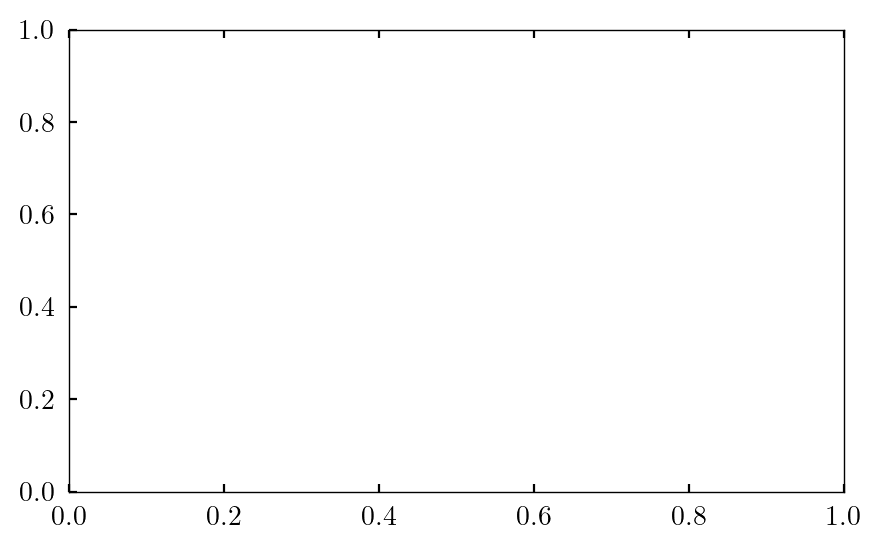

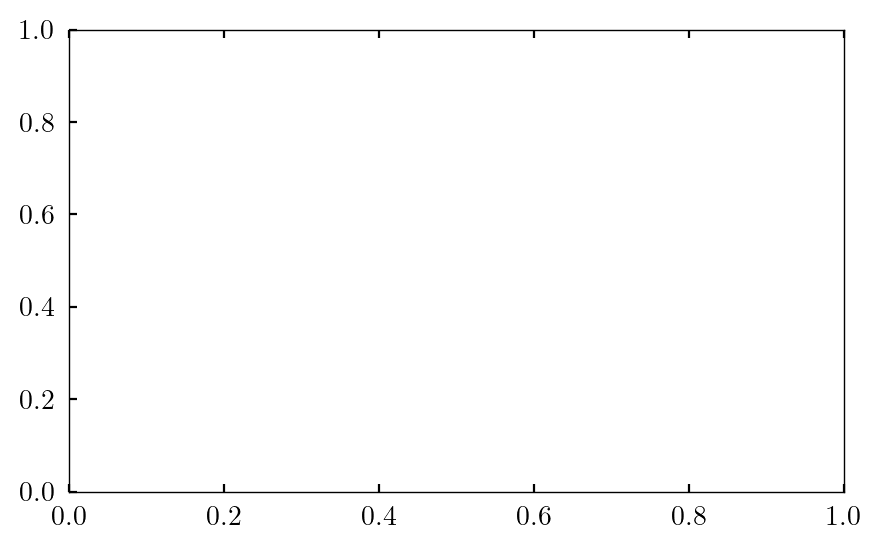

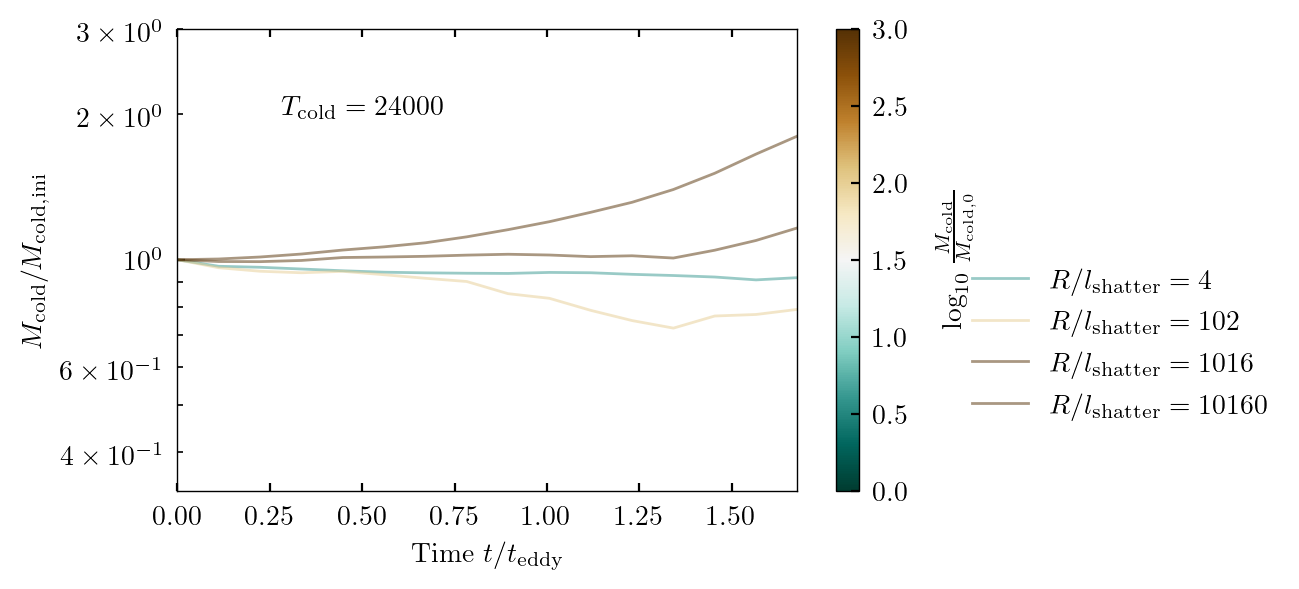

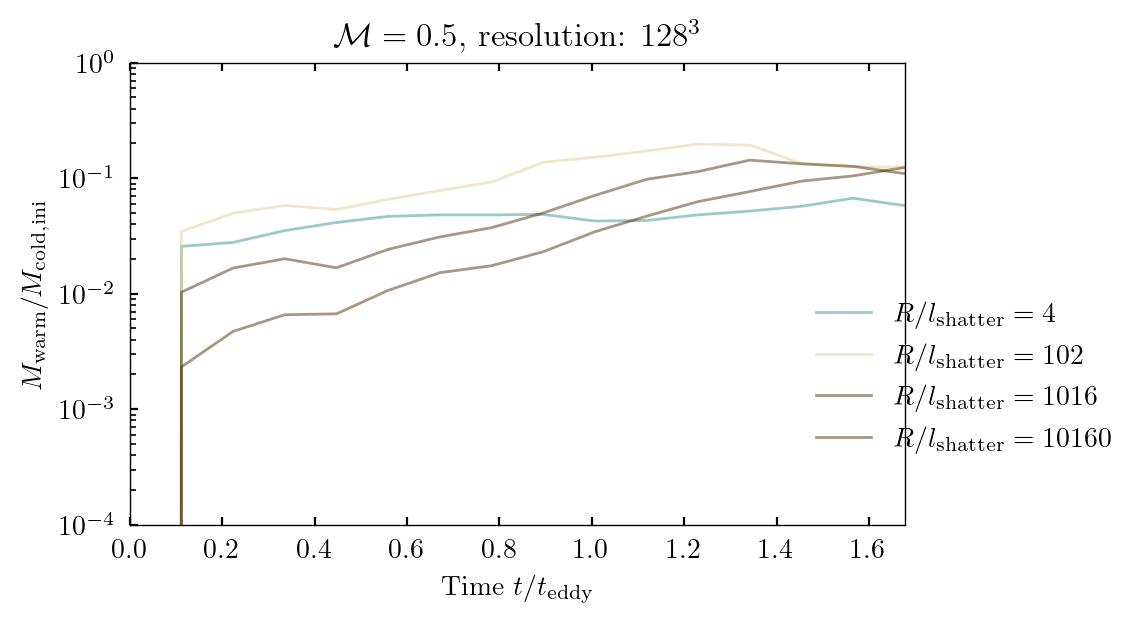

In [30]:
# Choose within cold_cloud_ratio_list = [2, 3, 5, 10]
plot_evol_all_ratio(mach=0.5, cold_cloud_ratio=3)

In [29]:
# Choose within cold_cloud_ratio_list = [2, 3, 5, 10]
plot_evol_all_ratio(mach=0.3, cold_cloud_ratio=5)


KeyboardInterrupt



In [ ]:
# Choose within cold_cloud_ratio_list = [2, 3, 5, 10]
plot_evol_all_ratio(mach=0.3, cold_cloud_ratio=10)